Student 1 : Philippe BERNET

Student 2 : Marius   DUBOSC

Student 3 : Baptiste BOURDET

In [1]:
import ipywidgets as widgets
from IPython.display import display
import os
import pandas as pd

from datetime import date, datetime

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import when, count, col, hour, mean, year, window, udf, avg, month, min, max, dayofmonth, weekofyear, lag, isnull

from pyspark.sql.window import Window

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["figure.figsize"] = (12, 10)
# %matplotlib widget

In [2]:
data_folder = "stocks_data/"
companies = ['AMAZON',
             'APPLE',
             'FACEBOOK',
             'GOOGLE',
             'MICROSOFT',
             'TESLA',
             'ZOOM']


In [3]:
spark_application_name = "Spark_Application_Project"
spark = (SparkSession.builder.appName(spark_application_name).getOrCreate())

/home/marius/.local/lib/python3.6/site-packages/pyspark/context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


# Data loading

In [4]:
dfCol = StructType([StructField("Date",TimestampType()), StructField("High",DoubleType()), StructField("Low",DoubleType()), StructField("Open",DoubleType()), StructField("Close",DoubleType()), StructField("Volume", DoubleType()), StructField("Adj Close", DoubleType()), StructField("company_name",StringType())])
dfSchema = StructType(dfCol)

df = spark.read.csv(data_folder, header=True, sep=',', schema=dfSchema)
df.show()

+-------------------+------------------+------------------+------------------+------------------+---------+------------------+------------+
|               Date|              High|               Low|              Open|             Close|   Volume|         Adj Close|company_name|
+-------------------+------------------+------------------+------------------+------------------+---------+------------------+------------+
|2017-01-03 00:00:00| 62.84000015258789|62.130001068115234|62.790000915527344| 62.58000183105469|2.06941E7| 58.67324447631836|   MICROSOFT|
|2017-01-04 00:00:00|             62.75|62.119998931884766| 62.47999954223633| 62.29999923706055|  2.134E7| 58.41072463989258|   MICROSOFT|
|2017-01-05 00:00:00| 62.65999984741211|62.029998779296875|62.189998626708984| 62.29999923706055| 2.4876E7| 58.41072463989258|   MICROSOFT|
|2017-01-06 00:00:00|63.150001525878906|62.040000915527344| 62.29999923706055| 62.84000015258789|1.99229E7|58.917015075683594|   MICROSOFT|
|2017-01-09 00:00:00

# Data available

The following function allow you to explore the dataset. A widget is available to facilitate the visualisation and allow to dynamically change the stock.

In [5]:
def explore_ds(df, input):
	df_one = df.filter(df.company_name == input).orderBy('Date')

	# Show the first and last 40 rows of stock price
	print('First 40 lines :')
	spark.createDataFrame(df_one.head(40)).show(40)
	print('Last 40 lines :')
	spark.createDataFrame(df_one.tail(40)).show(40)

	# Get the number of observations
	print(f'Number of observations : {df_one.count()}')

	# Period
	dini = df_one.select(min('Date')).collect()[0][0]
	dfin = df_one.select(max('Date')).collect()[0][0]
	inter = (dfin - dini).days
	print(f'Period between {dini} and {dfin} : {inter} days')

	# Descriptive statistics
	print('Statistics :')
	df_one.summary().show()

	# Number of missing values
	print('Missing values :')
	df_one.select([count(when(col(c).isNull(), c)).alias(c) for c in df_one.columns]).show()

	# Correlation between values
	cols = ["High", "Low", "Open", "Close", "Volume", "Adj Close"]
	for i in range(len(cols)):
		for j in range(i + 1, len(cols)):
			print(f"Correlation {cols[i]}/{cols[j]}: {df_one.corr(cols[i], cols[j])}")


In [6]:
def display_info_by_company(df):
    w_output = widgets.Output()
    w_inputs = widgets.Dropdown(
        options=[(companies[i], i) for i in range(len(companies))],
        value=0,
        description="Input",
    )

    def intern_display(change):
        w_output.clear_output()
        with w_output:
            input = w_inputs.options[w_inputs.value][0]
            explore_ds(df, input)
        
    w_inputs.observe(intern_display)
    display(w_inputs)
    display(w_output)

display_info_by_company(df)

Dropdown(description='Input', options=(('AMAZON', 0), ('APPLE', 1), ('FACEBOOK', 2), ('GOOGLE', 3), ('MICROSOF…

Output()

## Exploration

In [7]:
# used to change date granularity
granularity = {
    'day' : ['company_name', year('Date').alias('year'), month('Date').alias('month'),  dayofmonth('Date').alias('day')],
    'week' : ['company_name', year('Date').alias('year'), weekofyear('Date').alias('week')],
    'month' : ['company_name', year('Date').alias('year'), month('Date').alias('month')],
    'year' : ['company_name', year('Date').alias('year')]
}

# used to visualize the data in chronological order
order_by = {
	'day' : ['year', 'month', 'day'],
	'week' : ['year', 'week'],
	'month' : ['year', 'month'],
	'year' : ['year'],
}

columns = ['Close', 'Open', 'High', 'Low', 'Volume', 'Adj Close']

We start the exploration by computing the average values for the open and close price as well as the volume for dfferent time periods.

In [8]:
def compute_average(cur_df, gran = 'year', cols = (mean('Open').alias('Open_Mean'), mean('Close').alias('Close_mean'), mean('Volume').alias('Volume_mean'))):
    return (cur_df
    .groupBy(granularity[gran])
    .agg(*cols).orderBy(order_by[gran]))

We then compute the variation of the average values of the close price and the volume.

In [9]:
def compute_variation(cur_df, gran = 'year', cols = (mean('Close').alias('Close_mean'), mean('Volume').alias('Volume_mean'))):
    cur_df = compute_average(df, gran, cols)
    my_window = Window.partitionBy("company_name").orderBy(order_by[gran])
    cur_df = cur_df.withColumn("prev_close", lag(cur_df.Close_mean).over(my_window))
    cur_df = cur_df.withColumn("Close_diff", when(isnull(cur_df.Close_mean - cur_df.prev_close), 0)
                            .otherwise(cur_df.Close_mean - cur_df.prev_close))
    cur_df = cur_df.drop("prev_close")

    cur_df = cur_df.withColumn("prev_volume", lag(cur_df.Volume_mean).over(my_window))
    cur_df = cur_df.withColumn("Volume_diff", when(isnull(cur_df.Volume_mean - cur_df.prev_volume), 0)
                                .otherwise(cur_df.Volume_mean - cur_df.prev_volume))
    cur_df = cur_df.drop("prev_volume")
    return cur_df

The following function is a generic function enabling dynamic visualisation with widgets.

In [10]:
def display_frame(func, df, cols = (mean('Open').alias('Open_Mean'), mean('Close').alias('Close_mean'), mean('Volume').alias('Volume_mean'))):
    w_granu = widgets.RadioButtons(
        options=granularity.keys(),
        value=list(granularity.keys())[0],
        description="Granularity",
    )

    w_output_g = widgets.Output()

    def f(change):
        w_output_g.clear_output()
        with w_output_g :
            func(df, w_granu.value, cols).show()
                

    w_granu.observe(f)
    display(w_granu)
    display(w_output_g)


In [11]:
display_frame(compute_variation, df)

RadioButtons(description='Granularity', options=('day', 'week', 'month', 'year'), value='day')

Output()

We add a column containing the daily return.

In [12]:
# Daily return
def add_daily_return(df):
	return df.withColumn('Daily return', col('Open') - col('Close'))

df_dr = add_daily_return(df)
df_dr.show()

+-------------------+------------------+------------------+------------------+------------------+---------+------------------+------------+--------------------+
|               Date|              High|               Low|              Open|             Close|   Volume|         Adj Close|company_name|        Daily return|
+-------------------+------------------+------------------+------------------+------------------+---------+------------------+------------+--------------------+
|2017-01-03 00:00:00| 62.84000015258789|62.130001068115234|62.790000915527344| 62.58000183105469|2.06941E7| 58.67324447631836|   MICROSOFT| 0.20999908447265625|
|2017-01-04 00:00:00|             62.75|62.119998931884766| 62.47999954223633| 62.29999923706055|  2.134E7| 58.41072463989258|   MICROSOFT| 0.18000030517578125|
|2017-01-05 00:00:00| 62.65999984741211|62.029998779296875|62.189998626708984| 62.29999923706055| 2.4876E7| 58.41072463989258|   MICROSOFT| -0.1100006103515625|
|2017-01-06 00:00:00|63.1500015258

Max daily return :

In [13]:
# Highest daily return
def get_max_daily_return(df):
	df = add_daily_return(df)
	return df.select(max('Daily return')).collect()[0][0]

In [14]:
max_daily_return = get_max_daily_return(df)
df_dr.filter(col('Daily return') == max_daily_return).show()

+-------------------+---------------+-----------------+----------------+------+---------+---------+------------+---------------+
|               Date|           High|              Low|            Open| Close|   Volume|Adj Close|company_name|   Daily return|
+-------------------+---------------+-----------------+----------------+------+---------+---------+------------+---------------+
|2020-07-13 00:00:00|3344.2900390625|3068.389892578125|3251.06005859375|3104.0|7720400.0|   3104.0|      AMAZON|147.06005859375|
+-------------------+---------------+-----------------+----------------+------+---------+---------+------------+---------------+



Visualisation of the average daily return for different time periods :

In [15]:
def get_average_daily_return(df, gran, var):
    df = add_daily_return(df)
    return compute_average(df, gran, var)

display_frame(get_average_daily_return, df, (mean('Open').alias('Open_Mean'), mean('Close').alias('Close_mean'), mean('Daily return').alias('Average daily return')))

RadioButtons(description='Granularity', options=('day', 'week', 'month', 'year'), value='day')

Output()

We can also plot these values, to better visualize them.

In [16]:
def plot_frame(df):
	colors = {
		'APPLE': 'r',
		'AMAZON': 'b',
		'FACEBOOK': 'c',
		'GOOGLE': 'y',
		'MICROSOFT': 'm',
		'TESLA': 'k',
		'ZOOM': 'g'
	}

	fig, axs = plt.subplots(3, 3)

	j = 0
	for gran in ['year', 'week', 'day']:
		df_tmp = compute_average(df, gran, (mean('Daily return').alias('Daily return Mean'),
											mean('Open').alias('Open Mean'), 
											mean('Close').alias('Close mean'), 
											min('Date').alias('Date')))
		min_date = df_tmp.select(min('Date')).collect()[0][0]
		max_date = df_tmp.select(max('Date')).collect()[0][0]
		
		i = 0
		for cur_graph in ['Close', 'Open', 'Daily return']:

			for name, color in colors.items():
				tmp_col = (df_tmp
						.orderBy('Date')
						.filter(df_tmp.company_name == name))
				axs[i, j].plot(tmp_col.select('Date').collect(),
							tmp_col.select(cur_graph + ' Mean').collect(),
							color=color,
							label=name)

			axs[i, j].set_xlim((min_date, max_date))
			axs[i, j].set_title(f'{cur_graph} of stocks per {gran}')

			i += 1

		j += 1

	axs[0, 0].legend()

	plt.show()


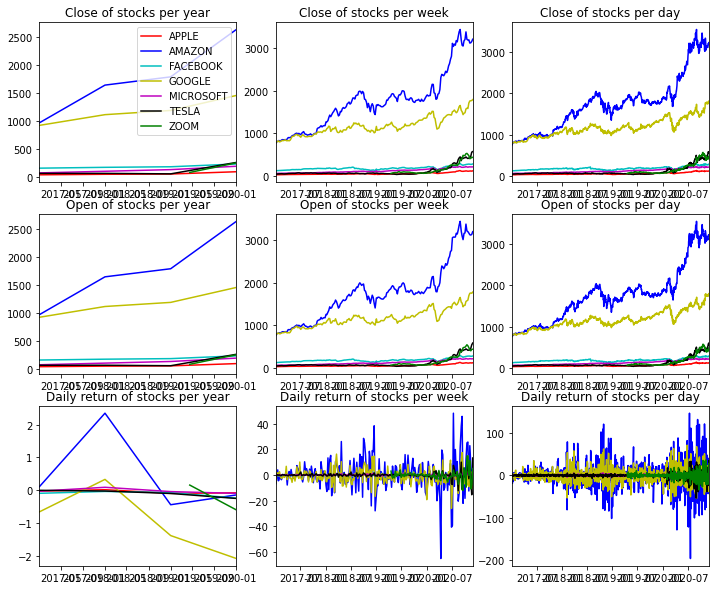

In [17]:
plot_frame(df_dr)

# Moving Average

A good metric is the moving average, that better show global tendancies

In [18]:
def moving_average(dataframe, column_name, nb_point):
    def days(i): 
        return i * 86400
    w = Window().partitionBy("company_name").orderBy(col("Date").cast('long')).rangeBetween(-days(nb_point), 0)

    return dataframe.withColumn('Moving average', avg(column_name).over(w))

In [19]:
moving_average(df, 'Close', 5).show()

+-------------------+-----------------+-----------------+-----------------+-----------------+---------+-----------------+------------+-----------------+
|               Date|             High|              Low|             Open|            Close|   Volume|        Adj Close|company_name|   Moving average|
+-------------------+-----------------+-----------------+-----------------+-----------------+---------+-----------------+------------+-----------------+
|2017-01-03 00:00:00| 758.760009765625|747.7000122070312|757.9199829101562|753.6699829101562|3521100.0|753.6699829101562|      AMAZON|753.6699829101562|
|2017-01-04 00:00:00|759.6799926757812|754.2000122070312|758.3900146484375|757.1799926757812|2510500.0|757.1799926757812|      AMAZON|755.4249877929688|
|2017-01-05 00:00:00|782.4000244140625| 760.260009765625|761.5499877929688|780.4500122070312|5830100.0|780.4500122070312|      AMAZON|763.7666625976562|
|2017-01-06 00:00:00|799.4400024414062|  778.47998046875|782.3599853515625| 795.98

# Correlation

We can display the coefficient of correlations between columns

In [20]:
from pyspark.sql.functions import corr

def correlation(data_frame_A, data_frame_B, col_name):
    """
        data_frame_A: has one column Date to join the data
        data_frame_B: has one column Date to join the data
        col_name: must be present in both data frame
    """
    return data_frame_A.join(data_frame_B.withColumnRenamed(col_name, col_name + "_B"), on="Date",how="inner").corr(col_name, col_name + "_B")

In [21]:
def display_cor(df):
    w_output = widgets.Output()
    w_inputs_A = widgets.Dropdown(
        options=[(companies[i], i) for i in range(len(companies))],
        value=0,
        description="Company A",
    )
    w_inputs_B = widgets.Dropdown(
        options=[(companies[i], i) for i in range(len(companies))],
        value=0,
        description="Company B",
    )
    
    w_inputs_column = widgets.Dropdown(
        options=[(columns[i], i) for i in range(len(columns))],
        value=0,
        description="Column",
    )

    all_w_inputs = [w_inputs_A, w_inputs_B ,w_inputs_column]

    def cor_display(change):
        w_output.clear_output()
        with w_output:
            comp_A = w_inputs_A.options[w_inputs_A.value][0]
            company_A_df = df.filter(df.company_name == comp_A)
            
            comp_B = w_inputs_B.options[w_inputs_B.value][0]
            company_B_df = df.filter(df.company_name == comp_B)
            
            column = w_inputs_column.options[w_inputs_column.value][0]
            
            print(correlation(company_A_df, company_B_df, column))

    for w in all_w_inputs:
        w.observe(cor_display)
        display(w)
    display(w_output)

display_cor(df)

Dropdown(description='Company A', options=(('AMAZON', 0), ('APPLE', 1), ('FACEBOOK', 2), ('GOOGLE', 3), ('MICR…

Dropdown(description='Company B', options=(('AMAZON', 0), ('APPLE', 1), ('FACEBOOK', 2), ('GOOGLE', 3), ('MICR…

Dropdown(description='Column', options=(('Close', 0), ('Open', 1), ('High', 2), ('Low', 3), ('Volume', 4), ('A…

Output()

We can plot correlation matrices for better visualisation

In [22]:
def compute_corr_for_col(df, col_name, companies):

    corr = [None] * len(companies)
    for i, comp in enumerate(companies):
        corr[i] = [0.0] * len(companies)
        for j in range(i):
            corr[i][j] = corr[j][i]
        for j, other in enumerate(companies[i:]):
            corr[i][i + j] = correlation(df.filter(df.company_name == comp), df.filter(df.company_name == other), col_name)
    
    return spark.createDataFrame(
        corr, ','.join([f"{c} float" for c in companies])
    )



def display_corr_for_cols(df, cols, companies, uniform_bar=False):
    w = 3
    h =  len(cols) // 3 + (0 if len(cols) % 3 == 0 else 1)
    fig, axs = plt.subplots(h, w, figsize=(22, h * 4))
    
    for i, col in enumerate(cols):
        df_corr = compute_corr_for_col(df, col, companies)
        ax = axs[i // 3, i % 3] if len(cols) > 3 else axs[i]
        mat = ax.matshow(df_corr.collect())
        plt.sca(ax)
        plt.xticks(range(len(companies)), companies, fontsize=14, rotation=45)
        plt.yticks(range(len(companies)), companies, fontsize=14)
        cb = fig.colorbar(mat, ax=ax,fraction=0.05, pad=0.08)
        if uniform_bar:
            mat.set_clim(-1, 1)
        ax.tick_params(labelsize=14)
        ax.title.set_text(f"Correlation Matrix for column {col}");
    
    for j in range(len(cols), w * h):
        ax = axs[j // 3, j % 3] if len(cols) > 3 else axs[j]
        ax.axis('off')
        
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=1, 
                    hspace=0.6)
    plt.show()

Py4JJavaError: An error occurred while calling o6869.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 4 in stage 1737.0 failed 1 times, most recent failure: Lost task 4.0 in stage 1737.0 (TID 2732) (172.24.33.137 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 481, in main
    raise RuntimeError(("Python in worker has different version %s than that in " +
RuntimeError: Python in worker has different version 3.9 than that in driver 3.6, PySpark cannot run with different minor versions. Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:555)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:713)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:695)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:508)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:349)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:898)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:898)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2454)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2402)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2402)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1160)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2642)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2584)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2573)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2214)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2235)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2254)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2279)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:394)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3538)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3706)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3704)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3535)
	at jdk.internal.reflect.GeneratedMethodAccessor87.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 481, in main
    raise RuntimeError(("Python in worker has different version %s than that in " +
RuntimeError: Python in worker has different version 3.9 than that in driver 3.6, PySpark cannot run with different minor versions. Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:555)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:713)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:695)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:508)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:349)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:898)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:898)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


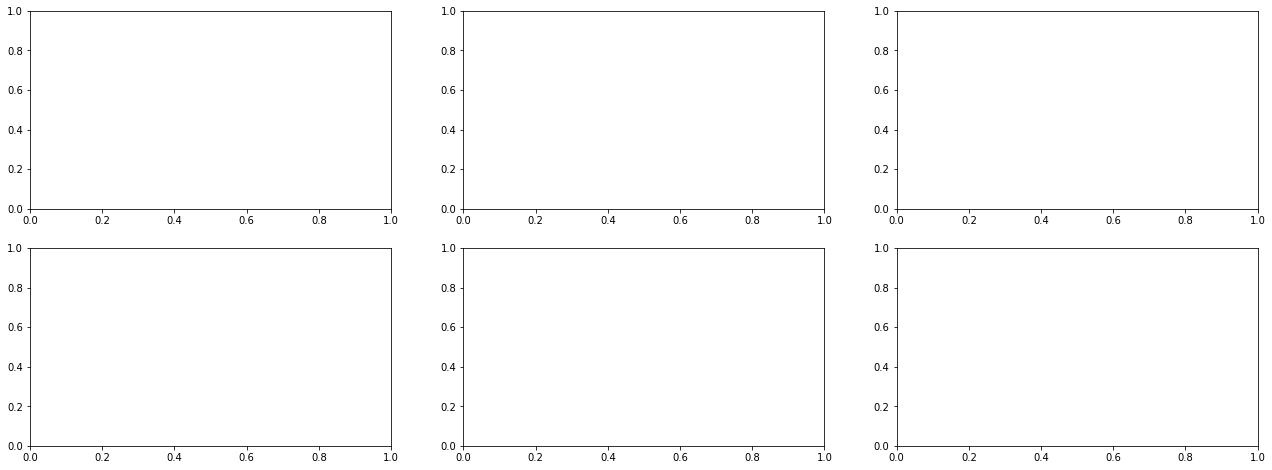

In [62]:
display_corr_for_cols(df, ['Volume', 'Low', 'High', 'Open', 'Close', 'Adj Close'], companies)

display_corr_for_cols(df, ['Volume', 'Low', 'High', 'Open', 'Close', 'Adj Close'], companies, uniform_bar=True)

# Return rate

We can display the return rate, which indicates the net gain or loss of an investment over a specified time period, expressed as a percentage of the investment’s initial cost.

In [25]:
def compute_return_rate(cur_df, gran, var):
    cur_df = compute_variation(cur_df, gran, var)
    cur_df = cur_df.withColumn("Return_rate", when(isnull(cur_df.Close_diff / cur_df.Close_mean * 100), 0)
                            .otherwise(cur_df.Close_diff / cur_df.Close_mean * 100))
    return cur_df

In [26]:
display_frame(compute_return_rate, df, (mean('Open').alias('Open_Mean'), mean('Close').alias('Close_mean'), mean('Volume').alias('Volume_mean')))

RadioButtons(description='Granularity', options=('day', 'week', 'month', 'year'), value='day')

Output()

# Best return rate

We can also return the company with the best return rate for a given month

In [27]:
from dateutil.relativedelta import relativedelta

def best_return_rate(data_frame, initial_date_str, gran):
    if gran == "month":
        period_size = relativedelta(months=1)
        date = datetime.strptime(initial_date_str, '%Y-%m').date()
    elif gran == "year":
        period_size = relativedelta(years=1)
        date = datetime.strptime(initial_date_str, '%Y').date()
    else:
        print('Bad granularity, accepted are : month or year')
        return
    
    initial_date = date
    end_date = date + period_size
    
    df = compute_return_rate(data_frame, gran, (mean('Open').alias('Open_Mean'), mean('Close').alias('Close_mean'), mean('Volume').alias('Volume_mean'), min('Date').alias('Date')))
    
    df = df.filter(df.Date >= initial_date)
    df = df.filter(df.Date < end_date)
    
    df = df.select('Date', 'company_name', 'Return_rate')
    
    max_rr = df.select(max('Return_rate')).collect()[0][0]
    df = df.filter(df.Return_rate == max_rr) 
    
    return df

In [28]:
best_return_rate(df, '2018', 'year').show()

+-------------------+------------+-----------------+
|               Date|company_name|      Return_rate|
+-------------------+------------+-----------------+
|2018-01-02 00:00:00|      AMAZON|41.02749740637896|
+-------------------+------------+-----------------+



# Insights

Some insights that we can implement :

- stability (différence between 'High' and 'Low')
- add median
- add standart deviation and interquartile difference
- stocks prediction with time series prediciton model (RNN)
- lowest daily return
- lowest return rate

# Prediction

In this section, we predict futur Open - Close - High - Low according to the previous one (the last date available in the dataset). This can be computed following different granularity (day, week, month (not enough data for years)), with different lag value and for different offsets.

In [29]:
def buildRegDF(df, company, gran="day", max_lag=5, data_cols = ['Close', 'Open', 'High', 'Low'], lag_cols = ['Close', 'Open', 'High', 'Low']):
    # cols = (min('Date').alias('Date'), mean('Close').alias('Close'), mean('Open').alias('Open'), mean('High').alias('High'), mean('Low').alias('Low'))
    cols = [min('Date').alias('Date')]
    for col in data_cols:
        cols.append(mean(col).alias(col))
    
    df_base = df.filter(df.company_name == company)

    df_lr = compute_average(df_base, gran, cols)
    my_window = Window.orderBy(order_by[gran])

    inputCols = []
    for i in range(1, max_lag):
        for c in lag_cols :
            col_name = f"{c} {gran}-{i}"
            df_lr = df_lr.withColumn(col_name, lag(df_lr[c], i).over(my_window))
            inputCols.append(col_name)

    df_lr = df_lr.dropna()
    return df_lr, inputCols

In [30]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, IsotonicRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import lit

def buildRegPipelineModel(df_lr, colToEstimate, inputCols):
    trainDF, testDF = df_lr.randomSplit([.8, .2], seed=42)
    print(f"There are {trainDF.cache().count()} rows in the training set, and {testDF.cache().count()} in the test set")

    vecAssembler = VectorAssembler(inputCols=inputCols, outputCol="features")

    reg = LinearRegression(featuresCol="features", labelCol=colToEstimate) 

    pipeline = Pipeline(stages=[vecAssembler, reg])
    pipelineModel = pipeline.fit(trainDF)

    predTrainDF = pipelineModel.transform(trainDF)
    predTestDF = pipelineModel.transform(testDF)

    regressionMeanEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol=colToEstimate, metricName="rmse")

    print(f"The RMSE for predicting the {colToEstimate} (train) is: {regressionMeanEvaluator.evaluate(predTrainDF):.2f}")
    print(f"The RMSE for predicting the {colToEstimate} (test) is: {regressionMeanEvaluator.evaluate(predTestDF):.2f}")

    return pipelineModel



In [31]:
from pyspark.sql.functions import date_add, add_months

def shiftColumn(df, inputCols, cols_name):
    cols_shift = cols_name + inputCols
    for i in range(len(cols_shift) - 1, len(cols_name) - 1, -1):
        df = df.withColumn(cols_shift[i], col(cols_shift[i - len(cols_name)]))
    return df

def predictCaracteristic(df, company, offset, gran="day", max_lag=2, lag_cols = ['Close', 'Open', 'High', 'Low'], data_cols = ['Close', 'Open', 'High', 'Low']):
    df_lr, inputCols = buildRegDF(df, company, gran, max_lag, lag_cols=lag_cols, data_cols=data_cols)

    mDate = df_lr.select(max('Date')).collect()[0][0]
    last_line = df_lr.orderBy(col('Date').asc()).filter(df_lr.Date == mDate)

    pipelines = [buildRegPipelineModel(df_lr, col, inputCols) for col in lag_cols]

    predictions = last_line.select(lag_cols).withColumn("Date", lit(mDate))
    
    for i in range(offset):
        last_line = shiftColumn(last_line, inputCols, lag_cols)
        for ch in range(len(lag_cols)):
            last_line = pipelines[ch].transform(last_line)
            last_line = last_line.withColumn(lag_cols[ch], last_line.prediction).drop("prediction", "features")
        
        if gran == "year":
            c_date = date_add(lit(mDate), 12 * (i + 1))
        elif gran == "month":
            c_date = add_months(lit(mDate), i + 1)
        elif gran == "week":
            c_date = date_add(lit(mDate), 7 * (i + 1))
        else:
            c_date = date_add(lit(mDate), i + 1)
        
        predictions = predictions.union(last_line.select(data_cols).withColumn("Date", lit(c_date)))
    
    return predictions

In [32]:
# import tensorflow as tf
# from tensorflow.keras import Sequential
import numpy as np

import tensorflow.keras.models as km
import tensorflow.keras.layers as kl

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [67]:
def build_model(data_cols):
	inputs = kl.Input((None, len(data_cols)))
	x = kl.GRU(units=15 * len(data_cols), return_sequences=True)(inputs)
	# x = kl.TimeDistributed(kl.Dense(20, activation='relu'))(x)
	outputs = kl.TimeDistributed(kl.Dense(len(data_cols), activation='linear'))(x)
	model = km.Model(inputs, outputs)

	model.compile(loss="mae", optimizer='adam', metrics=['mse'])
	return model

In [55]:
def get_data(arr, data_cols, offset):
	arr = arr.reshape(arr.shape[0], -1, len(data_cols))
	pre, post, = arr[:, :-offset], arr[:, offset:]
	return train_test_split(pre, post, test_size=0.2, shuffle=False)

In [89]:

def predict_gru(df, company, offset=1, gran="day", max_lag=2, data_cols = ['Close', 'Open', 'High', 'Low'], global_train=False, scale=True):
	if global_train:
		res = None
		for comp in companies:
			temp, _ = buildRegDF(df, comp, gran=gran, max_lag = max_lag, lag_cols = data_cols, data_cols = data_cols)
			if res is None : 
				res = temp
			else :
				res = res.union(temp)
			if comp == company :
				arr = np.array(res.drop('company_name', 'year', 'month', 'day', 'Date').collect())
				_, X_test, _, y_test = get_data(arr, data_cols, offset)
	else:
		res, _ = buildRegDF(df, company, gran=gran, max_lag = max_lag, lag_cols = data_cols, data_cols = data_cols)
		
	arr = np.array(res.drop('company_name', 'year', 'month', 'day', 'Date').collect())
	
	if scale:
		scaler = MinMaxScaler()
		arr = scaler.fit_transform(arr)
  
	if not global_train:
		X_train, X_test, y_train, y_test = get_data(arr, data_cols, offset)
	else :
		X_train, _, y_train, _ = get_data(arr, data_cols, offset)
		
	
	model = build_model(data_cols)
	model.fit(X_train, y_train, batch_size = 20, validation_split=0.2, epochs=10)
 
	y_pred = model.predict(X_test)
	y_pred = y_pred.reshape(y_pred.shape[0], -1)
 
	# rescaling
	if scale:
		max_val = scaler.data_max_[:y_pred.shape[1]]
		min_val = scaler.data_min_[:y_pred.shape[1]]
		y_pred = (y_pred*(max_val - min_val)) + min_val
 
	y_pred = y_pred.reshape(y_pred.shape[0], -1, len(data_cols))
 
	for i in range(len(data_cols)):
		print(f"The RMSE for predicting the {data_cols[i]} (train) is: {mean_squared_error(y_pred[:,:,i], y_test.reshape(y_pred.shape)[:,:,i], squared=False):.2f}")
		print(f"The RMSE for predicting the {data_cols[i]} (test) is: {mean_squared_error(y_pred[:,:,i], y_test.reshape(y_pred.shape)[:,:,i], squared=False):.2f}")

In [81]:
def display_prediction(df):
	w_output = widgets.Output()
	w_company = widgets.Dropdown(
		options=[(companies[i], i) for i in range(len(companies))],
		value=0,
		description="Company",
	)

	granularity_name = list(granularity.keys())
	granularity_name.remove("year")
	w_input_granularity = widgets.Dropdown(
		options=[(granularity_name[i], i)
				 for i in range(len(granularity_name))],
		value=0,
		description="Granularity",
	)

	w_int_lag = widgets.IntText(
		value=5,
		min=0,
		max=20,
		step=1,
		description='Lag'
	)

	w_int_offset = widgets.IntText(
		value=1,
		min=0,
		max=20,
		step=1,
		description='Offset'
	)
	
	w_pred_model = widgets.Dropdown(
		options=["Linear Regression", "Recurrent Neural Network (GRU)"],
		value="Linear Regression",
		description="Prediction model",
	)

	all_w = [w_company, w_input_granularity, w_int_lag, w_int_offset, w_pred_model]

	def display_prediction_intern(change):
		w_output.clear_output()
		with w_output:
			comp = w_company.options[w_company.value][0]
			gran = w_input_granularity.options[w_input_granularity.value][0]
			lag = w_int_lag.value
			offset = w_int_offset.value
   
			if w_pred_model == "Linear Regression":
				predictCaracteristic(df, comp, offset, gran, lag).show()
			else :
				predict_gru(df, comp, offset=offset, gran=gran, max_lag=lag, global_train=False)
			

	for w in all_w:
		w.observe(display_prediction_intern)
	display(widgets.Box(children=all_w))
	display(w_output)
	display(w_pred_model)


display_prediction(df)

Box(children=(Dropdown(description='Company', options=(('AMAZON', 0), ('APPLE', 1), ('FACEBOOK', 2), ('GOOGLE'…

Output()

Dropdown(description='Prediction model', options=('Linear Regression', 'Recurrent Neural Network (GRU)'), valu…

In [90]:
def display_gru(df):
	w_output = widgets.Output()
	w_company = widgets.Dropdown(
		options=[(companies[i], i) for i in range(len(companies))],
		value=0,
		description="Company",
	)

	granularity_name = list(granularity.keys())
	granularity_name.remove("year")
	w_input_granularity = widgets.Dropdown(
		options=[(granularity_name[i], i)
				 for i in range(len(granularity_name))],
		value=0,
		description="Granularity",
	)

	w_int_lag = widgets.IntText(
		value=5,
		min=0,
		max=20,
		step=1,
		description='Lag'
	)

	w_int_offset = widgets.IntText(
		value=1,
		min=0,
		max=20,
		step=1,
		description='Offset'
	)
 
	w_scale = widgets.Checkbox(
		value=True,
		description='Normalize',
		disabled=False,
		indent=False
	)
 
	w_close = widgets.Checkbox(
		value=True,
		description='Close',
		disabled=False,
		indent=False
	)

	w_open = widgets.Checkbox(
		value=True,
		description='Open',
		disabled=False,
		indent=False
	)
  
	w_high = widgets.Checkbox(
		value=True,
		description='High',
		disabled=False,
		indent=False
	)
 
	w_low = widgets.Checkbox(
		value=True,
		description='Low',
		disabled=False,
		indent=False
	)

	all_w = [w_company, w_input_granularity, w_int_lag, w_int_offset, w_scale, w_close, w_open, w_high, w_low]

	def display_prediction_intern(change):
		w_output.clear_output()
		with w_output:
			comp = w_company.options[w_company.value][0]
			gran = w_input_granularity.options[w_input_granularity.value][0]
			lag = w_int_lag.value
			offset = w_int_offset.value
			scale = w_scale.value
			data_cols = []
			if (w_close.value):
				data_cols.append('Close')
			if (w_open.value):
				data_cols.append('Open')
			if (w_high.value):
				data_cols.append('High')
			if (w_low.value):
				data_cols.append('Low')
			predict_gru(df, comp, offset=offset, gran=gran, max_lag=lag, data_cols=data_cols, scale=scale, global_train=False)
			

	for w in all_w:
		w.observe(display_prediction_intern)
	display(widgets.Box(children=all_w))
	display(w_output)


display_gru(df)

Box(children=(Dropdown(description='Company', options=(('AMAZON', 0), ('APPLE', 1), ('FACEBOOK', 2), ('GOOGLE'…

Output()